In [2]:
import pandas as pd
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

# Simulated Data

In [5]:
#df = pd.read_csv("Dataset_Clean.csv")
df=pd.read_csv('simulated_data_twf.csv')
#df=pd.read_csv('Optimized_Data.csv')
df.shape

(10000, 14)

In [6]:
df.head()

,Unnamed: 0,UDI,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],TWF,Temp_Delta,Power,Planned_Stop,Time/Part,Failures
0,0,1,M,298.1,308.6,1551,42.8,0,0,10.5,6951.590560,0,3,0
1,1,2,L,298.2,308.7,1408,46.3,3,0,10.5,6826.722724,0,2,0
2,2,3,L,298.1,308.5,1498,49.4,5,0,10.4,7749.387543,0,2,0
3,3,4,L,298.2,308.6,1433,39.5,7,0,10.4,5927.504659,0,2,0
4,4,5,L,298.2,308.7,1408,40.0,9,0,10.5,5897.816608,0,2,0


In [7]:
num_data = ['Air temperature [K]','Process temperature [K]','Rotational speed [rpm]','Torque [Nm]','Temp_Delta','Tool wear [min]']
categorical = ['Type','Timing']
target1 = ['Failures']
target2 = ['TWF']

# Consider Maximum Batches within 200 min

In [8]:
df['Total_parts'] = df.apply(lambda x: 0 if x['Failures']==1 or x['TWF']==1 else 1, axis=1)
df['Total_parts'].sum()

9933

In [9]:
total = df['Time/Part'].sum()
stop = df['Failures'].sum() + df['TWF'].sum()
total_parts = df['Total_parts'].sum()

print(f"Machine works in total: {total-(stop*30):.2f} min, {(total-(stop*30))/60:.2f} hours ")
print(f"Machine failures: {stop} times")
print(f'Rate: {stop/total*60:.2f} stops/ hour')
print(f"Total Approved Produced: {total_parts}, Total part scraped:{stop} parts, Percentage scraped:{stop/total_parts*100}%, Total waste time:{((stop*30)/22)/456:.2f} hours/day")


Machine works in total: 23996.00 min, 399.93 hours 
Machine failures: 67 times
Rate: 0.15 stops/ hour
Total Approved Produced: 9933, Total part scraped:67 parts, Percentage scraped:0.674519279170442%, Total waste time:0.20 hours/day


In [10]:

product = 0
batch = []

for total_parts, planned_stop in zip(df['Total_parts'], df['Planned_Stop']):
    if total_parts == 1 or planned_stop == 1:
        product += 1
    elif product > 0:
        batch.append(product)
        product = 0

# Check if there's an unfinished batch
if product > 0:
    batch.append(product)

print(f'Batches: {batch}')
print(f'Total batches: {len(batch)}')
print(f'Total products: {sum(batch)}')


Batches: [25, 380, 171, 12, 255, 410, 35, 73, 49, 268, 225, 147, 128, 358, 14, 204, 92, 39, 205, 293, 156, 370, 133, 18, 25, 142, 58, 373, 162, 296, 96, 142, 74, 30, 135, 101, 8, 215, 9, 16, 418, 123, 79, 131, 247, 64, 49, 77, 77, 191, 38, 3, 75, 24, 25, 174, 93, 367, 1, 655, 44, 580, 132, 155, 65, 76, 28]
Total batches: 67
Total products: 9933


In [11]:
df_approved = df[(df[ 'Failures']==0) & (df['TWF']==0)]
df_approved.shape

(9933, 15)

In [12]:
import random

class TaskOptimizer:
    def __init__(self, task_times):
        self.task_times = task_times
        self.list_batch = []
        
    def sort_tasks(self):
        self.task_times.sort(reverse=True)

    def random_distribution(self):
        random.shuffle(self.task_times)

    def optimize_task_distribution(self, schedule_duration):
        schedules = []  
    
        while self.task_times:
            current_schedule = []  
            remaining_duration = schedule_duration
            i = 0
            
            while i < len(self.task_times):
                task_time = self.task_times[i]
                if task_time <= remaining_duration:
                    current_schedule.append(task_time)
                    remaining_duration -= task_time
                    self.task_times.pop(i)
                else:
                    i += 1
            schedules.append(current_schedule)
        
        return schedules
    
    def calculate_total_time(self, optimized_schedules):
        total_time = sum(sum(schedule) for schedule in optimized_schedules)
        return total_time
    
    def get_list_batch(self):
        return self.list_batch

    def print_optimized_schedules(self, optimized_schedules):
        total_time = self.calculate_total_time(optimized_schedules)
        total_parts = sum(len(schedule) for schedule in optimized_schedules)
        for i, schedule in enumerate(optimized_schedules):
            task_list = ', '.join(map(str, schedule))
            counter = len(schedule)
            self.list_batch.append(counter)
            print(f"Batch {i + 1}/Product:{counter}/ Total time: {sum(schedule)} minutes / Product List:{task_list}")
            
        total_schedules = len(optimized_schedules)
        print(f"Total stops for maintenance: {(total_schedules)} times")
        print(f'Batch List:{self.list_batch}')
        #print(f"Total worked consumed: {total_time} minutes")
        print(f"Machine works in total: {total_time:.2f} min, {total_time/60:.2f} hours")
        print(f"Total parts produced: {total_parts}")   

task_times = df_approved['Time/Part'].tolist()
schedule_duration = 200

optimizer = TaskOptimizer(task_times)
optimizer.sort_tasks() 
optimizer.random_distribution()
optimized_schedules = optimizer.optimize_task_distribution(schedule_duration)
optimizer.print_optimized_schedules(optimized_schedules)

list_batch_values = optimizer.get_list_batch()


Batch 1/Product:80/ Total time: 199 minutes / Product List:3, 2, 2, 2, 2, 3, 2, 2, 2, 2, 3, 2, 3, 3, 2, 2, 2, 2, 2, 3, 3, 2, 5, 2, 2, 2, 2, 2, 3, 5, 2, 2, 3, 5, 2, 2, 2, 2, 3, 5, 2, 2, 2, 2, 2, 2, 3, 2, 2, 3, 3, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 5, 5, 2, 2, 3, 2, 5, 2, 2, 3, 3, 2, 2, 3, 2, 2, 2, 2
Batch 2/Product:75/ Total time: 200 minutes / Product List:3, 2, 2, 5, 3, 2, 2, 2, 2, 2, 2, 5, 5, 3, 3, 2, 5, 2, 3, 3, 3, 2, 3, 3, 2, 2, 2, 2, 2, 3, 5, 2, 5, 5, 3, 2, 2, 3, 3, 2, 3, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 3, 2, 5, 3, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 5, 3, 2, 5, 3
Batch 3/Product:73/ Total time: 199 minutes / Product List:2, 3, 2, 2, 3, 3, 5, 3, 2, 5, 3, 2, 3, 3, 2, 5, 5, 2, 2, 5, 2, 3, 2, 2, 5, 2, 2, 2, 3, 2, 2, 3, 2, 3, 3, 2, 3, 5, 2, 3, 2, 2, 5, 2, 3, 2, 3, 2, 2, 2, 2, 2, 2, 3, 3, 2, 3, 2, 2, 3, 3, 3, 2, 2, 3, 2, 3, 3, 2, 5, 3, 2, 2
Batch 4/Product:79/ Total time: 200 minutes / Product List:2, 2, 3, 3, 2, 3, 2, 2, 5, 5, 3, 3, 2, 3, 2, 2, 3, 2, 2, 3, 2, 2, 5, 3, 2, 3, 2, 3,

# BEFORE

In [32]:
df_actual =  pd.read_csv("Dataset_Clean.csv")
df_actual.head()

,Unnamed: 0,UDI,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],TWF,Temp_Delta,Power,Planned_Stop,Time/Part,Failures
0,0,1,M,298.1,308.6,1551,42.8,0,0,10.5,6951.590560,0,3,0
1,1,2,L,298.2,308.7,1408,46.3,3,0,10.5,6826.722724,0,2,0
2,2,3,L,298.1,308.5,1498,49.4,5,0,10.4,7749.387543,0,2,0
3,3,4,L,298.2,308.6,1433,39.5,7,0,10.4,5927.504659,0,2,0
4,4,5,L,298.2,308.7,1408,40.0,9,0,10.5,5897.816608,0,2,0


In [33]:
df_actual.reset_index(drop = True, inplace = True)
df_actual = df_actual.drop(columns=['Unnamed: 0'])

In [34]:
num_data = ['Air temperature [K]','Process temperature [K]','Rotational speed [rpm]','Torque [Nm]','Tool wear [min]','Temp_Delta', 'Power']
categorical = ['Type', 'Time/Part', 'Planned_Stop']

target1 = ['Failures']
target2 = ['TWF']

In [35]:
df_actual['Total_parts'] = df_actual.apply(lambda x: 0 if x['Failures']==1 or x['TWF']==1 else 1, axis=1)
print(df_actual['Total_parts'].sum())
print(df_actual['Planned_Stop'].sum())

9661
64


In [36]:
total = df_actual['Time/Part'].sum()
stop = df_actual['Failures'].sum() + df_actual['TWF'].sum()
total_parts = df_actual['Total_parts'].sum()

print(f"Machine works in total: {total-(stop*30):.2f} min, {(total-(stop*30))/60:.2f} hours ")
print(f"Machine failures: {stop} times")
print(f'Rate: {stop/total*60:.2f} stops/ hour')
print(f"Total Approved Produced: {total_parts}, Total part scraped:{stop} parts, Percentage scraped:{stop/total_parts*100}%, Total waste time:{((stop*30)/22)/456:.2f} hours/day")


Machine works in total: 15836.00 min, 263.93 hours 
Machine failures: 339 times
Rate: 0.78 stops/ hour
Total Approved Produced: 9661, Total part scraped:339 parts, Percentage scraped:3.508953524479867%, Total waste time:1.01 hours/day


In [37]:
product = 0
batch = []

for total_parts, planned_stop in zip(df_actual['Total_parts'], df_actual['Planned_Stop']):
    if total_parts == 1 or planned_stop == 1:
        product += 1
    elif product > 0:
        batch.append(product)
        product = 0

# Check if there's an unfinished batch
if product > 0:
    batch.append(product)

print(f'Batches: {batch}')
print(f'Total batches: {len(batch)}')
print(f'Total products: {sum(batch)}')

Batches: [50, 18, 7, 82, 6, 25, 12, 34, 5, 9, 67, 52, 61, 20, 122, 16, 142, 100, 32, 22, 22, 89, 68, 1, 7, 27, 19, 16, 4, 116, 39, 9, 55, 27, 17, 54, 3, 12, 73, 11, 86, 80, 20, 4, 18, 24, 162, 18, 59, 49, 40, 66, 10, 54, 31, 93, 17, 49, 7, 78, 16, 72, 77, 11, 96, 5, 14, 61, 58, 18, 120, 95, 29, 83, 5, 12, 87, 70, 49, 31, 72, 10, 64, 26, 5, 12, 7, 14, 24, 10, 1, 60, 6, 7, 58, 21, 7, 1, 9, 3, 22, 6, 1, 5, 8, 20, 1, 8, 7, 1, 10, 1, 1, 1, 6, 5, 2, 5, 2, 1, 21, 3, 13, 21, 1, 1, 1, 3, 11, 8, 2, 1, 6, 3, 10, 15, 2, 1, 13, 10, 1, 5, 8, 12, 1, 3, 1, 8, 4, 2, 7, 1, 1, 5, 7, 5, 6, 12, 6, 5, 4, 14, 5, 8, 16, 5, 2, 7, 11, 1, 6, 4, 8, 16, 3, 9, 6, 1, 10, 9, 2, 4, 9, 3, 3, 14, 17, 15, 1, 2, 3, 1, 1, 5, 1, 8, 6, 3, 1, 5, 1, 7, 35, 1, 14, 1, 2, 3, 3, 6, 68, 15, 39, 7, 3, 8, 50, 12, 79, 77, 89, 24, 59, 4, 86, 1, 45, 78, 1, 88, 27, 174, 31, 57, 24, 53, 74, 5, 12, 5, 69, 6, 83, 78, 58, 18, 27, 14, 77, 54, 4, 80, 39, 124, 7, 57, 20, 71, 3, 79, 112, 145, 82, 25, 27, 4, 21, 1, 75, 17, 68, 2, 3, 85, 34, 41, 7

In [38]:
print(len(optimized_schedules))
print(len(batch))

145
311


In [39]:
df_actual.head()

,UDI,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],TWF,Temp_Delta,Power,Planned_Stop,Time/Part,Failures,Total_parts
0,1,M,298.1,308.6,1551,42.8,0,0,10.5,6951.590560,0,3,0,1
1,2,L,298.2,308.7,1408,46.3,3,0,10.5,6826.722724,0,2,0,1
2,3,L,298.1,308.5,1498,49.4,5,0,10.4,7749.387543,0,2,0,1
3,4,L,298.2,308.6,1433,39.5,7,0,10.4,5927.504659,0,2,0,1
4,5,L,298.2,308.7,1408,40.0,9,0,10.5,5897.816608,0,2,0,1


In [40]:
df_approved.head()

,Unnamed: 0,UDI,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],TWF,Temp_Delta,Power,Planned_Stop,Time/Part,Failures,Total_parts
0,0,1,M,298.1,308.6,1551,42.8,0,0,10.5,6951.590560,0,3,0,1
1,1,2,L,298.2,308.7,1408,46.3,3,0,10.5,6826.722724,0,2,0,1
2,2,3,L,298.1,308.5,1498,49.4,5,0,10.4,7749.387543,0,2,0,1
3,3,4,L,298.2,308.6,1433,39.5,7,0,10.4,5927.504659,0,2,0,1
4,4,5,L,298.2,308.7,1408,40.0,9,0,10.5,5897.816608,0,2,0,1


In [41]:
import random

class TaskOptimizer:
    def __init__(self, task_times):
        self.task_times = task_times
        self.list_batch = []
        
    def sort_tasks(self):
        self.task_times.sort(reverse=True)

    def random_distribution(self):
        random.shuffle(self.task_times)

    def optimize_task_distribution(self, schedule_duration):
        schedules = []  
    
        while self.task_times:
            current_schedule = []  
            remaining_duration = schedule_duration
            i = 0
            
            while i < len(self.task_times):
                task_time = self.task_times[i]
                if task_time <= remaining_duration:
                    current_schedule.append(task_time)
                    remaining_duration -= task_time
                    self.task_times.pop(i)
                else:
                    i += 1
            schedules.append(current_schedule)
        
        return schedules
    
    def calculate_total_time(self, optimized_schedules):
        total_time = sum(sum(schedule) for schedule in optimized_schedules)
        return total_time
    
    def get_list_batch(self):
        return self.list_batch

    def print_optimized_schedules(self, optimized_schedules):
        total_time = self.calculate_total_time(optimized_schedules)
        total_parts = sum(len(schedule) for schedule in optimized_schedules)
        for i, schedule in enumerate(optimized_schedules):
            task_list = ', '.join(map(str, schedule))
            counter = len(schedule)
            self.list_batch.append(counter)
            print(f"Batch {i + 1}/Product:{counter}/ Total time: {sum(schedule)} minutes / Product List:{task_list}")
            
        total_schedules = len(optimized_schedules)
        print(f"Total stops for maintenance: {(total_schedules)} times")
        print(f'Batch List:{self.list_batch}')
        #print(f"Total worked consumed: {total_time} minutes")
        print(f"Machine works in total: {total_time:.2f} min, {total_time/60:.2f} hours")
        print(f"Total parts produced: {total_parts}")   

task_times = df_actual['Time/Part'].tolist()
schedule_duration = 180

optimizer = TaskOptimizer(task_times)
optimizer.sort_tasks() 
optimizer.random_distribution()
optimized_schedules = optimizer.optimize_task_distribution(schedule_duration)
optimizer.print_optimized_schedules(optimized_schedules)

list_batch_values = optimizer.get_list_batch()


Batch 1/Product:69/ Total time: 180 minutes / Product List:2, 2, 2, 3, 2, 3, 2, 2, 2, 2, 3, 2, 2, 5, 2, 5, 2, 2, 2, 2, 3, 2, 5, 2, 3, 2, 3, 3, 2, 2, 2, 2, 3, 2, 3, 2, 2, 3, 3, 2, 3, 2, 2, 2, 3, 2, 5, 5, 2, 2, 3, 3, 3, 2, 2, 3, 3, 2, 2, 2, 3, 2, 5, 2, 2, 3, 5, 3, 2
Batch 2/Product:69/ Total time: 179 minutes / Product List:3, 2, 2, 3, 2, 2, 2, 3, 5, 2, 3, 5, 2, 2, 2, 3, 3, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 5, 2, 3, 2, 2, 2, 3, 2, 2, 5, 5, 2, 3, 2, 2, 2, 3, 5, 2, 3, 2, 2, 2, 2, 3, 5, 2, 3, 3, 2, 2, 3, 2, 3, 2, 3, 2, 2, 3, 2, 3
Batch 3/Product:69/ Total time: 179 minutes / Product List:3, 2, 2, 3, 2, 2, 5, 3, 2, 2, 2, 2, 2, 5, 2, 3, 2, 5, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 3, 2, 2, 2, 5, 3, 3, 2, 2, 3, 2, 2, 3, 3, 3, 3, 5, 5, 2, 5, 2, 3, 3, 2, 3, 2, 2, 3, 2, 3, 3, 2, 2
Batch 4/Product:70/ Total time: 180 minutes / Product List:2, 3, 5, 2, 3, 3, 2, 3, 3, 2, 2, 3, 3, 2, 2, 2, 3, 5, 2, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 5, 3, 5, 2, 2, 3, 3, 2, 5, 2, 2, 2, 2, 3, 2, 2, 3, 2, 5, 2,

# COMPARISON

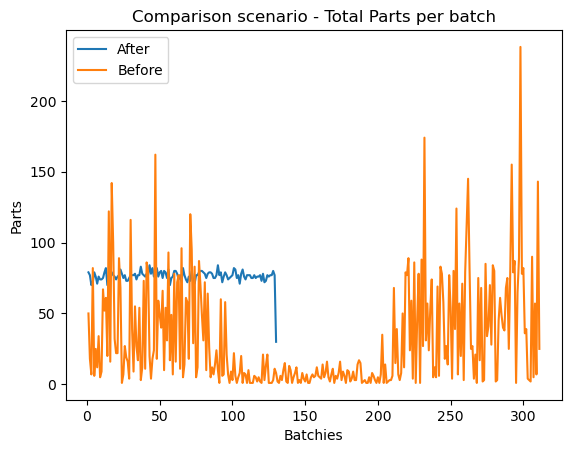

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Assuming list_batch_values and batch are your data lists
ln_list_batch_values = range(1, len(list_batch_values) + 1)
ln_batch = range(1, len(batch) + 1)

# Create DataFrames for both lists
df_list_batch_values = pd.DataFrame({'Time': ln_list_batch_values, 'Values': list_batch_values})
df_batch = pd.DataFrame({'Time': ln_batch, 'Values': batch})

# Merging both DataFrames on the 'Time' column
df_merged = pd.merge(df_list_batch_values, df_batch, on='Time', how='outer', suffixes=('_list_batch_values', '_batch'))

# Creating a line plot using Seaborn
sns.lineplot(x='Time', y='Values_list_batch_values', data=df_merged, label='After')
sns.lineplot(x='Time', y='Values_batch', data=df_merged, label='Before')

# Adding labels and title
plt.xlabel('Batchies')
plt.ylabel('Parts')
plt.title('Comparison scenario - Total Parts per batch')

# Show the plot
plt.legend()
plt.show()


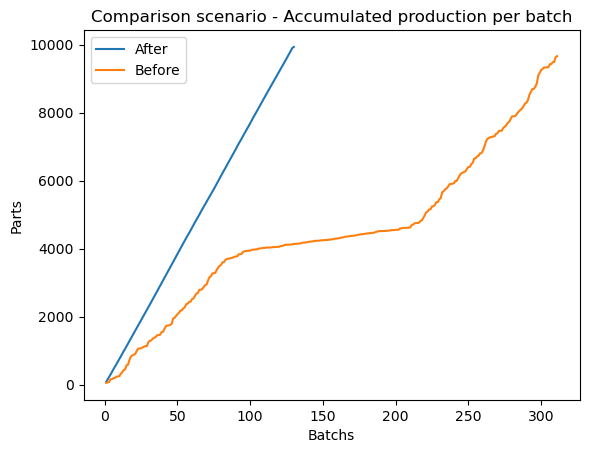

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Assuming list_batch_values and batch are your data lists
ln_list_batch_values = range(1, len(list_batch_values) + 1)
ln_batch = range(1, len(batch) + 1)

# Create DataFrames for both lists
df_list_batch_values = pd.DataFrame({'Time': ln_list_batch_values, 'Values': list_batch_values})
df_batch = pd.DataFrame({'Time': ln_batch, 'Values': batch})

# Calculate cumulative sum for both lists
df_list_batch_values['CumulativeSum_list_batch_values'] = df_list_batch_values['Values'].cumsum()
df_batch['CumulativeSum_batch'] = df_batch['Values'].cumsum()

# Merging both DataFrames on the 'Time' column
df_merged = pd.merge(df_list_batch_values, df_batch, on='Time', how='outer')

# Creating a line plot using Seaborn for cumulative sums
sns.lineplot(x='Time', y='CumulativeSum_list_batch_values', data=df_merged, label='After')
sns.lineplot(x='Time', y='CumulativeSum_batch', data=df_merged, label='Before')

# Adding labels and title
plt.xlabel('Batchs')
plt.ylabel('Parts')
plt.title('Comparison scenario - Accumulated production per batch')

# Show the plot
plt.legend()
plt.show()


# Simulated with Limited

In [ ]:
class TaskScheduler:
    def __init__(self, task_times):
        self.task_times = task_times
        self.list_batch = []

    def sort_tasks(self):
        self.task_times.sort()

    def random_distribution(self):
        pass

    def optimize_task_distribution(self, schedule_duration, min_tasks_per_schedule, max_tasks_per_schedule):
        schedules = []

        while self.task_times:
            current_schedule = []
            remaining_duration = schedule_duration
            i = 0

            while i < len(self.task_times):
                task_time = self.task_times[i]

                if task_time <= remaining_duration:
                    current_schedule.append(task_time)
                    remaining_duration -= task_time
                    self.task_times.pop(i)
                else:
                    i += 1

            num_tasks = len(current_schedule)
            if min_tasks_per_schedule <= num_tasks <= max_tasks_per_schedule:
                schedules.append(current_schedule)

        return schedules

    def calculate_total_time(self, optimized_schedules):
        total_time = sum(sum(schedule) for schedule in optimized_schedules)
        return total_time

    def get_list_batch(self):
        return self.list_batch

    def print_optimized_schedules(self, optimized_schedules):
        total_time = self.calculate_total_time(optimized_schedules)
        total_parts = sum(len(schedule) for schedule in optimized_schedules)
        for i, schedule in enumerate(optimized_schedules):
            task_list = ', '.join(map(str, schedule))
            counter = len(schedule)
            self.list_batch.append(counter)
            print(f"Batch {i + 1}/Product:{counter}/ Total time: {sum(schedule)} minutes / Product List:{task_list}")

        total_schedules = len(optimized_schedules)
        print(f"Total stops for maintenance: {(total_schedules)} times")
        print(f'Batch List:{self.list_batch}')
        print(f"Machine works in total: {total_time:.2f} min, {total_time / 60:.2f} hours")
        print(f"Total parts produced: {total_parts}")


task_times = df_approved['Part_Time'].tolist()
schedule_duration = 200

optimizer1 = TaskScheduler(task_times)
optimizer1.sort_tasks()
optimizer1.random_distribution()
optimized_schedules = optimizer1.optimize_task_distribution(schedule_duration, min_tasks_per_schedule=40,
                                                            max_tasks_per_schedule=100)
optimizer1.print_optimized_schedules(optimized_schedules)

list_batch_values = optimizer1.get_list_batch()
